In [2]:
import pandas as pd
df = pd.read_csv('/Users/carlitos/Desktop/ProteinDesign/ProteinDesign/pdb_data_seq.csv')

In [3]:
print(df.columns)

Index(['structureId', 'chainId', 'sequence', 'residueCount',
       'macromoleculeType'],
      dtype='object')


In [4]:
protein_seq = df.query('macromoleculeType == "Protein"')['sequence']
print(protein_seq)

4         MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
7         MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...
8         MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
11        MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...
12        MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
                                ...                        
467299    MNYQPTPEDRFTFGLWTVGWQGRDPFGDATRRALDPVESVQRLAEL...
467300    SVQATREDKFSFGLWTVGWQARDAFGDATRTALDPVEAVHKLAEIG...
467301    SVQATREDKFSFGLWTVGWQARDAFGDATRTALDPVEAVHKLAEIG...
467302    SVQATREDKFSFGLWTVGWQARDAFGDATRTALDPVEAVHKLAEIG...
467303    SVQATREDKFSFGLWTVGWQARDAFGDATRTALDPVEAVHKLAEIG...
Name: sequence, Length: 345180, dtype: object


In [5]:
# we only need 20k protein sequences
protein_seq = protein_seq[:20000].reset_index(drop=True)
print(protein_seq)

0        MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
1        MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...
2        MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
3        MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...
4        MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
                               ...                        
19995    MNPDLRKERASATFNPELITHILDGSPENTRRRREIENLILNDPDF...
19996    MNPDLRKERASATFNPELITHILDGSPENTRRRREIENLILNDPDF...
19997    SDRAEVRNIPFKLGMYLTVGGVVNSNATRFSINVGESTDSIAMHMD...
19998    SDRAEVRNIPFKLGMYLTVGGVVNSNATRFSINVGESTDSIAMHMD...
19999    SDRAEVRNIPFKLGMYLTVGGVVNSNATRFSINVGESTDSIAMHMD...
Name: sequence, Length: 20000, dtype: object


In [6]:
# check nan values
protein_seq.isna().sum()

np.int64(1)

In [7]:
# drop nan
protein_seq = protein_seq.dropna()
len(protein_seq)

19999

In [8]:
# convert to list of protein sequences
proteins = protein_seq.tolist()
proteins[:3]

['MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRVKHLKTEAEMKASEDLKKHGVTVLTALGAILKKKGHHEAELKPLAQSHATKHKIPIKYLEFISEAIIHVLHSRHPGNFGADAQGAMNKALELFRKDIAAKYKELGYQG',
 'MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSELDKAIGRNTNGVITKDEAEKLFNQDVDAAVRGILRNAKLKPVYDSLDAVRRAALINMVFQMGETGVAGFTNSLRMLQQKRWDEAAVNLAKSRWYNQTPNRAKRVITTFRTGTWDAYKNL',
 'MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRFKHLKTEAEMKASEDLKKAGVTVLTALGAILKKKGHHEAELKPLAQSHATKHKIPIKYLEFISEAIIHVLHSRHPGNFGADAQGAMNKALELFRKDIAAKYKELGYQG']

In [9]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
# build a vocabulary of mapping the aa to integers
aa = list(set(''.join(proteins)))
stoi = {s:i+1 for i,s in enumerate(aa)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'D', 2: 'K', 3: 'P', 4: 'Q', 5: 'H', 6: 'R', 7: 'L', 8: 'G', 9: 'N', 10: 'F', 11: 'Z', 12: 'U', 13: 'W', 14: 'Y', 15: 'T', 16: 'M', 17: 'E', 18: 'X', 19: 'C', 20: 'I', 21: 'S', 22: 'V', 23: 'A', 0: '.'}
24


In [11]:
# let's build the dataset
block_size = 3 # context length

def build_dataset(proteins):
  X, Y = [], []

  for protein in proteins:
    #print(protein)
    context = [0] * block_size
    for aa in protein + '.':
      ix = stoi[aa]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(proteins)
n1 = int(0.8*len(proteins))
n2 = int(0.9*len(proteins))

Xtr, Ytr = build_dataset(proteins[:n1])      # 80%
Xdev, Ydev = build_dataset(proteins[n1:n2])  # 10%
Xte, Yte = build_dataset(proteins[n2:])      # 10%

torch.Size([3796221, 3]) torch.Size([3796221])
torch.Size([466658, 3]) torch.Size([466658])
torch.Size([482088, 3]) torch.Size([482088])


In [16]:
n_emb = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(42) # for reproducibility
C = torch.randn((vocab_size, n_emb),             generator=g)
W1 = torch.randn((block_size * n_emb, n_hidden), generator=g) * (5/3)/((n_emb * block_size)**0.5)
b1 = torch.randn(n_hidden,                       generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),         generator=g) * 0.01
b2 = torch.randn(vocab_size,                     generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # total number of parameters
for p in parameters:
  p.requires_grad = True


11664


In [17]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  # construct minibatch
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch x, batch y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  bnmeani = hpreact.mean(dim=0, keepdim=True)
  bnstdi = hpreact.std(dim=0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / (bnstdi + bnbias)
  
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log().item())

#print(loss.item())

      0/ 200000: 3.1928
  10000/ 200000: 3.0510
  20000/ 200000: 2.9139
  30000/ 200000: 2.9444
  40000/ 200000: 2.8250
  50000/ 200000: 2.8342
  60000/ 200000: 3.1188
  70000/ 200000: 2.9371
  80000/ 200000: 2.8351
  90000/ 200000: 3.0152
 100000/ 200000: 2.9252
 110000/ 200000: 3.0899
 120000/ 200000: 2.8035
 130000/ 200000: 2.8474
 140000/ 200000: 2.8072
 150000/ 200000: 2.7142
 160000/ 200000: 2.9266
 170000/ 200000: 2.8461
 180000/ 200000: 2.9626
 190000/ 200000: 2.8814


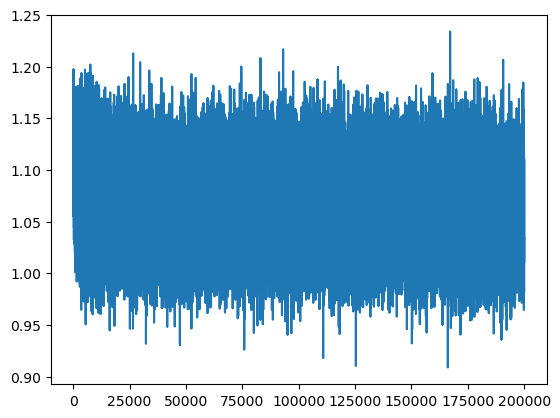

In [18]:
plt.plot(lossi)

In [20]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.998250961303711
val 2.998910903930664


In [ ]:
# sample from the model
g = torch.Generator().manual_seed(17)


for _ in range(3):

  out = []
  context = [0] * block_size
  while True:
    # forward pass of the neural net
    emb = C[torch.tensor([context])]
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    # sample from the distribution
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    # shift the context window and track the samples
    context = context[1:] + [ix]
    out.append(ix)
    # if we sample the special '.' token, break
    if ix == 0:
      break

  print(''.join(itos[i] for i in out)) # decode and print the generated protein

MNPYALSMTDVLAAAGESGILLKSTAYSNQTAQKVFEEWPIFPTSAFNDSGQEEGTATSAASVVPIEQKRIGHGIKIAAYALSELGGVNLREFDKGFFNKLVAPRDKLADVPTKPTALDNAIKNQDKAPKDTAAQTMADISLKEVAAKFLDRGEKITNIKPPRFVVVLFYERLCTEEDRGRKATVSCN.
SFETFKIHNKGVFLLDREIFSTYENDALIGTCLTINPAYKQIIHKMHEWKIRPNPKYAEKDERAFFDKMEEKAVLETPKVAPTSQGLCDLTESIIEATLDEAFVAGSTLKFLIGTYGGTTCLKGNKLLGRANSTKKVDSYPIHTRAVLAEKAVLTTPWSGNTPRAIWVNTVWPRTCILLSQFHNSILNYEISNAGIEGSKVHELIRQLLGSEARAAVLSVQADRRSCLVRARTILDIKHNAIPEYTPGGLTGHLLAFLRRRPFWSVATKRIHEIWKYGREIWNLIEVKSGSPV.
IAPARHEVDANVLPTWNIIWGREINERDLVQGKKLFKAWVFPKGAGNHIGTYGYYLPLEIPCRGNVEIKTGTQAVEPPPGETIMHLYLYDNRNTACYFTSCPYSTNAFPPDTQQHEAVGKIGLRSCCNAKIRYHPSEKGTDGHREFNGRPFRAGAQQNCMIAPRMLNPFYPDNSHIYNAWLLTR.
